#### Input

In [1]:
%load_ext nb_black
%load_ext autoreload

<IPython.core.display.Javascript object>

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from helpers import plot_class
from helpers import helpfunction as helper

pd.options.display.max_columns = None

<IPython.core.display.Javascript object>

### Constants

In [3]:
scale_pot = 6e20
input_dir = "./input/Jun2020/"
output_dir = "./output/nue/datamc/"

<IPython.core.display.Javascript object>

In [4]:
data = pd.read_pickle(input_dir + "after_training.pckl")
samples = list(data.keys())

<IPython.core.display.Javascript object>

In [5]:
sideband = True
if sideband:
    beam_on = "sideband"
    sideband_query = "(contained_fraction>0.9 & reco_e>1.05 & preselect)"
else:
    beam_on = "on"
    sideband_query = None

<IPython.core.display.Javascript object>

In [6]:
title_str = "MicroBooNE Run1-3: {:.1e}".format(data[beam_on]["pot"])

<IPython.core.display.Javascript object>

In [7]:
# Redo the categories from scratch:
# Do not use the fid vol of the analyser at all
q_1 = "true_fid_vol & abs(nu_pdg)==12 & nelec>0 & (npi0+npion)>0"
q_10 = "true_fid_vol & abs(nu_pdg)==12 & nelec>0 & nproton==0 & (npi0+npion)==0"
q_11 = "true_fid_vol & abs(nu_pdg)==12 & nelec>0 & nproton>0 & (npi0+npion)==0"
q_2 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & npi0==0"
q_21 = "true_fid_vol & abs(nu_pdg)==14 & nmuon>0 & npi0>0"
q_3 = "true_fid_vol & ~((abs(nu_pdg)==12 & nelec>0) | (abs(nu_pdg)==14 & nmuon>0)) & npi0==0"
q_31 = "true_fid_vol & ~((abs(nu_pdg)==12 & nelec>0) | (abs(nu_pdg)==14 & nmuon>0)) & npi0>0"
q_5 = "true_fid_vol==0"

for s in samples:
    if s not in helper.data_samples:
        add_mc_fields = ["nelec", "nmuon", "nu_purity_from_pfp"]
        for true_f in add_mc_fields:
            data[s]["daughters"][true_f] = np.repeat(
                data[s]["mc"][true_f], data[s]["mc"]["n_pfps"]
            )

        data[s]["daughters"]["true_fid_vol"] = np.repeat(
            helper.is_fid(
                data[s]["mc"]["true_nu_vtx_x"],
                data[s]["mc"]["true_nu_vtx_y"],
                data[s]["mc"]["true_nu_vtx_z"],
            ),
            data[s]["mc"]["n_pfps"],
        )

        new_cat = (
            data[s]["daughters"].eval(q_1) * 1
            + data[s]["daughters"].eval(q_10) * 10
            + data[s]["daughters"].eval(q_11) * 11
            + data[s]["daughters"].eval(q_2) * 2
            + data[s]["daughters"].eval(q_21) * 21
            + data[s]["daughters"].eval(q_3) * 3
            + data[s]["daughters"].eval(q_31) * 31
            + data[s]["daughters"].eval(q_5) * 5
        )
        data[s]["daughters"]["category"] = new_cat

        cosmic = (data[s]["daughters"]["nu_purity_from_pfp"] < 0.5) & (
            data[s]["daughters"]["category"] != 5
        )
        data[s]["daughters"].loc[cosmic, "category"] = 4

/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2858: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


<IPython.core.display.Javascript object>

In [8]:
print(list(data["nu"]["daughters"].keys()))

['n_showers', 'evt', 'secondshower_Y_eigenratio', 'backtracked_start_x', 'secondshower_Y_dot', 'hits_ratio', 'shr_tkfit_nhits_v', 'shr_tkfit_2cm_nhits_V', 'secondshower_Y_dir', 'reco_nu_vtx_sce_z', 'trkshrhitdist2', 'pfp_generation_v', 'backtracked_start_y', 'backtracked_pdg', 'trk_theta_v', 'shr_tkfit_2cm_dedx_Y', 'shr_energy_y_v', 'backtracked_px', 'shr_phi_v', 'NeutrinoEnergy2', 'contained_fraction', 'CosmicDirAll3D', 'trk_sce_end_x_v', 'SliceCaloEnergy2', 'pfp_trk_daughters_v', 'n_pfps', 'trk_score_v', 'trk_len_v', 'reco_nu_vtx_x', 'backtracked_completeness', 'trk_llr_pid_score_v', 'trk_sce_start_x_v', 'topological_score', 'pfnhits', 'shr_tkfit_gap10_dedx_y_v', 'CosmicIP', 'backtracked_overlay_purity', 'reco_nu_vtx_y', 'trk_phi_v', 'n_showers_contained', 'run', 'slpdg', 'backtracked_e', 'reco_nu_vtx_sce_y', 'shr_tkfit_dedx_y_v', 'trk_sce_start_y_v', 'shr_moliere_avg_v', 'merge_bestdist', 'trk_sce_start_z_v', 'merge_bestdot', 'n_tracks', 'shr_theta_v', 'shr_dist_v', 'pfp_shr_daughte

<IPython.core.display.Javascript object>

In [9]:
plotter = plot_class.Plotter(
    data, signal="nue", genie_version="mcc9.1", sideband_query=sideband_query
)

Using the spline weights as in MCC9.1 Genie V3 tune 1
All plots are scaled to 5.83e+20 POT, Beam_on data corresponds to 5.83e+20 POT
Initialisation completed!


<IPython.core.display.Javascript object>

In [10]:
del data
gc.collect()

233

<IPython.core.display.Javascript object>

### Plots

#### Additions to signal sample plots

In [11]:
# purity for every step per cat
cats = {2: 11, 1: 10, 3: 1}
selectors = ["daughter==0", "e_candidate & preselect", "e_candidate & select"]  # q_s
labs = ["NeutrinoID", "Pre-selection", "Selection"]

for selector, lab in zip(selectors, labs):
    print(
        "{} \tPurity: {:.2%}".format(lab, plotter.get_purity(selector, cats.values()))
    )

NeutrinoID 	Purity: 16.84%
Pre-selection 	Purity: 16.84%
Selection 	Purity: 71.87%


<IPython.core.display.Javascript object>

#### Data/MC comparison

MC category: $\nu_e$ CC other: 268. 	#entries 53025
MC category: $\nu_e$ CC 0$\pi$0p: 31. 	#entries 5204
MC category: $\nu_e$ CC 0$\pi$Np: 228. 	#entries 39871
MC category: $\nu_{\mu}$ CC other: 274. 	#entries 3900
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 1260. 	#entries 17467
MC category: $\nu$ NC: 62. 	#entries 1905
MC category: $\nu$ NC $\pi^{0}$: 421. 	#entries 3044
MC category: Cosmic: 523. 	#entries 7336
MC category: Out of FV: 69. 	#entries 811
MC category: Out of Cryo: 27. 	#entries 28


/home/wouter/Public/searchingfornues/helpers/plot_class.py:336: RuntimeWarning: divide by zero encountered in double_scalars
  sc_err = e / v
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/matplotlib/patches.py:716: RuntimeWarning: invalid value encountered in double_scalars
  self._y1 = self._y0 + self._height
/home/wouter/Public/searchingfornues/helpers/plot_class.py:358: RuntimeWarning: invalid value encountered in true_divide
  y_min_r = max(0, min((bins[-1]-err_on)/val)*0.9)
/home/wouter/Public/searchingfornues/helpers/plot_class.py:359: RuntimeWarning: invalid value encountered in true_divide
  y_max_r = min(2, max((bins[-1]+err_on)/val)*1.1)
/home/wouter/Public/searchingfornues/helpers/plot_class.py:365: RuntimeWarning: invalid value encountered in true_divide
  bins[-1] / val,
/home/wouter/Public/searchingfornues/helpers/plot_class.py:367: RuntimeWarning: invalid value encountered in true_divide
  yerr=err_on / val,


MC category: $\nu_e$ CC other: 268. 	#entries 53025
MC category: $\nu_e$ CC 0$\pi$0p: 31. 	#entries 5204
MC category: $\nu_e$ CC 0$\pi$Np: 228. 	#entries 39871
MC category: $\nu_{\mu}$ CC other: 274. 	#entries 3900
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 1260. 	#entries 17467
MC category: $\nu$ NC: 62. 	#entries 1905
MC category: $\nu$ NC $\pi^{0}$: 421. 	#entries 3044
MC category: Cosmic: 523. 	#entries 7336
MC category: Out of FV: 69. 	#entries 811
MC category: Out of Cryo: 27. 	#entries 28


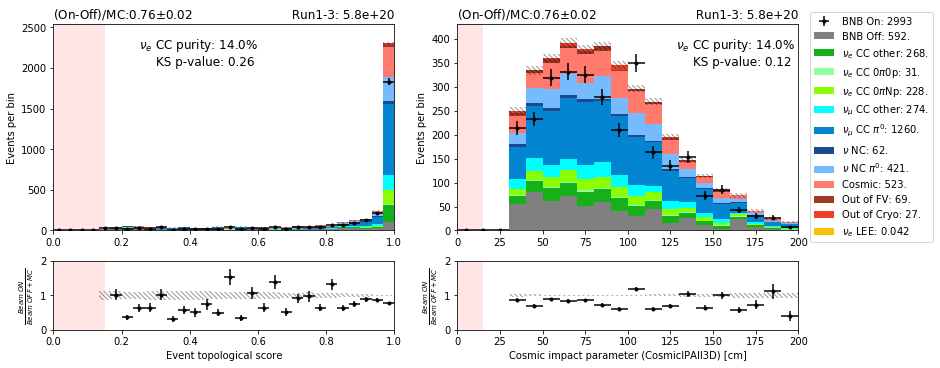

<IPython.core.display.Javascript object>

In [12]:
%autoreload
query = "(reco_fid_vol & slpdg==12 & contained_fraction>0.4 & optical_filter)"

fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ax[0][0].axvspan(0, 0.15, facecolor="red", alpha=0.1)
ax[1][0].axvspan(0, 0.15, facecolor="red", alpha=0.1)
ax[0][1].axvspan(0, 15, facecolor="red", alpha=0.1)
ax[1][1].axvspan(0, 15, facecolor="red", alpha=0.1)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "topological_score",
    r"Event topological score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query=query,
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.6,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "CosmicIPAll3D",
    r"Cosmic impact parameter (CosmicIPAll3D) [cm]",
    N_bins=20,
    x_min=0,
    x_max=200,
    query=query,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.99,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.savefig(output_dir + "topo_impact.pdf", bbox_inches="tight")

MC category: $p$: 67. 	#entries 3124
MC category: $\mu$: 287. 	#entries 3830
MC category: $e$: 174. 	#entries 30604
MC category: $\pi^{\pm}$: 120. 	#entries 5653
MC category: $\gamma$: 708. 	#entries 13465
MC category: $K$: 1.0 	#entries 36
MC category: Cosmic: 241. 	#entries 6230
MC category: $p$: 2.2 	#entries 52
MC category: $\mu$: 44. 	#entries 513
MC category: $e$: 165. 	#entries 29124
MC category: $\pi^{\pm}$: 8.3 	#entries 281
MC category: $\gamma$: 656. 	#entries 12366
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 160. 	#entries 3681


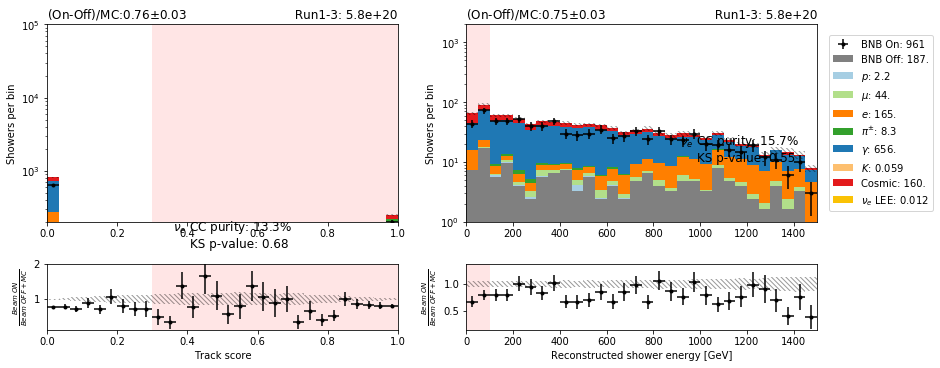

<IPython.core.display.Javascript object>

In [13]:
query = "optical_filter & \
         reco_fid_vol & \
         shr_energy_y_v>0 & \
         topological_score > 0.15 & \
         pfp_generation_v==2 & \
         trk_llr_pid_score_v>0.4 & \
         shr_tkfit_4cm_dedx_wm_v>0 & \
         shr_tkfit_dedx_y_v >0"


# the cosmic IP variables demand somehow that there is a shower in the event, therefore, they are left out of this cut.
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ax[0][0].axvspan(0.3, 1, facecolor="red", alpha=0.1)
ax[1][0].axvspan(0.3, 1, facecolor="red", alpha=0.1)
ax[0][1].axvspan(0, 100, facecolor="red", alpha=0.1)
ax[1][1].axvspan(0, 100, facecolor="red", alpha=0.1)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_score_v",
    r"Track score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query=query,
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
    y_label="Showers per bin",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.7,
    ax[0][0].get_ylim()[1] * 0.1,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

query += " & (trk_score_v<0.3) & \
             slpdg==12 & \
             contained_fraction>0.4 & \
             CosmicIPAll3D>30 & \
             CosmicDirAll3D>-0.98 & \
             CosmicDirAll3D<0.98"

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_energy_y_v",
    r"Reconstructed shower energy [GeV]",
    N_bins=30,
    x_min=0,
    x_max=1500,
    query=query,
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
    y_label="Showers per bin",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.95,
    ax[0][1].get_ylim()[1] * 0.1,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ax[0][0].set_ylim(200, 1e5)
ax[0][0].set_yscale("log")
ax[0][1].set_ylim(1, 2e3)
ax[0][1].set_yscale("log")

fig.savefig(output_dir + "trk_she.pdf", bbox_inches="tight")

MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363
MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363


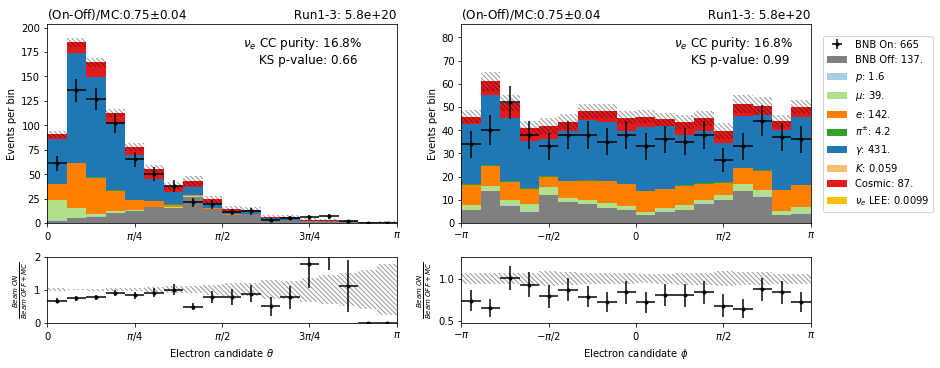

<IPython.core.display.Javascript object>

In [14]:
query = "(preselect & e_candidate)"

fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_theta_v",
    r"Electron candidate $\theta$",
    N_bins=18,
    x_min=0,
    x_max=np.pi,
    query=query,
    legend=False,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.9,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
x_ticks = [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi]
x_labels = [r"$0$", r"$\pi/4$", r"$\pi/2$", r"$3\pi/4$", r"$\pi$"]
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)


ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_phi_v",
    r"Electron candidate $\phi$",
    N_bins=18,
    x_min=-np.pi,
    x_max=np.pi,
    query=query,
    legend=True,
    title_str=title_str.split("NE")[-1],
    y_max_scaler=1.4,
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.9,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

x_ticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
x_labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)


fig.savefig(output_dir + "theta_phi.pdf", bbox_inches="tight")

## Shower fields
1. feature shr_dist_v (0.406786)
2. feature shr_moliere_avg_v (0.115516)
3. feature shr_tkfit_dedx_y_v (0.103206)
4. feature shr_tkfit_2cm_dedx_Y (0.088309)
5. feature shr_tkfit_4cm_dedx_wm_v (0.080856)
6. feature shr_tkfit_gap10_dedx_y_v (0.078377)
7. feature shr_subclusters_v (0.048331)
8. feature secondshower_Y_nhit (0.046542)
9. feature shr_tkfit_hitratio_v (0.032077)

MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363
MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363
MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363


/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


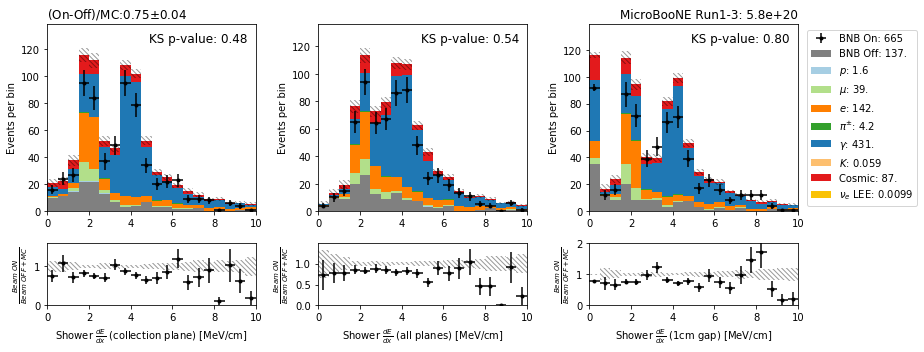

<IPython.core.display.Javascript object>

In [15]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_tkfit_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (collection plane) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
    y_max_scaler=1.2,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_tkfit_4cm_dedx_wm_v",
    r"Shower $\frac{dE}{dx}$ (all planes) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
    y_max_scaler=1.2,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "shr_tkfit_gap10_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (1cm gap) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
    y_max_scaler=1.2,
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.98,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")

fig.tight_layout()
fig.savefig(output_dir + "e_cand_dedx.pdf", bbox_inches="tight")

MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363


/home/wouter/Public/searchingfornues/helpers/plot_class.py:336: RuntimeWarning: divide by zero encountered in double_scalars
  sc_err = e / v
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/matplotlib/patches.py:716: RuntimeWarning: invalid value encountered in double_scalars
  self._y1 = self._y0 + self._height
/home/wouter/Public/searchingfornues/helpers/plot_class.py:358: RuntimeWarning: invalid value encountered in true_divide
  y_min_r = max(0, min((bins[-1]-err_on)/val)*0.9)
/home/wouter/Public/searchingfornues/helpers/plot_class.py:359: RuntimeWarning: invalid value encountered in true_divide
  y_max_r = min(2, max((bins[-1]+err_on)/val)*1.1)
/home/wouter/Public/searchingfornues/helpers/plot_class.py:365: RuntimeWarning: invalid value encountered in true_divide
  bins[-1] / val,
/home/wouter/Public/searchingfornues/helpers/plot_class.py:367: RuntimeWarning: invalid value encountered in true_divide
  yerr=err_on / val,


MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363
MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363


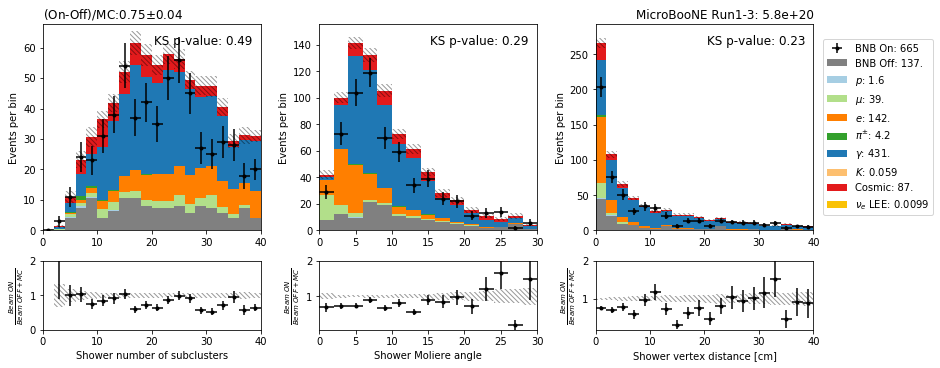

<IPython.core.display.Javascript object>

In [16]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_subclusters_v",
    r"Shower number of subclusters",
    N_bins=20,
    x_min=0,
    x_max=40,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_moliere_avg_v",
    r"Shower Moliere angle",
    N_bins=15,
    x_min=0,
    x_max=30,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "shr_dist_v",
    "Shower vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=40,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.98,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")

fig.savefig(output_dir + "e_cand_muonrejection.pdf", bbox_inches="tight")

MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363
MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363
MC category: $p$: 1.6 	#entries 26
MC category: $\mu$: 39. 	#entries 443
MC category: $e$: 142. 	#entries 24993
MC category: $\pi^{\pm}$: 4.2 	#entries 88
MC category: $\gamma$: 431. 	#entries 6245
MC category: $K$: 0.059 	#entries 1
MC category: Cosmic: 87. 	#entries 1363


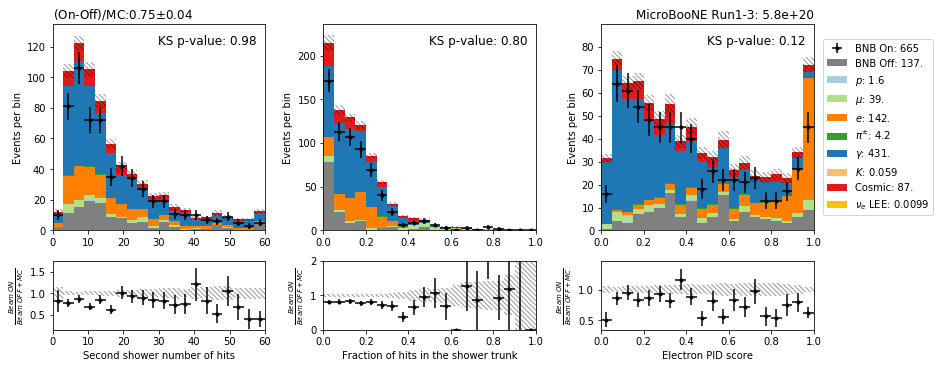

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "secondshower_Y_nhit",
    "Second shower number of hits",
    N_bins=20,
    x_min=0,
    x_max=60,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_tkfit_hitratio_v",
    r"Fraction of hits in the shower trunk",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "score",
    r"Electron PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
    y_max_scaler=1.2,
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.98,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")

fig.savefig(output_dir + "e_cand_second_score.pdf", bbox_inches="tight")

## Other daughter fields
1. feature trk_llr_pid_score_v (0.382910)
2. feature trk_distance_v (0.201966)
3. feature e_candidate_anglediff (0.081999)
4. feature trk_proton_hypothesis_ratio_v (0.071988)
5. feature trk_score_v (0.068836)
6. feature trk_muon_hypothesis_ratio_v (0.067883)
7. feature pfp_shr_daughters_v (0.050025)
8. feature pfp_generation_v (0.037862)
9. feature pfp_trk_daughters_v (0.036532)

MC category: $p$: 593. 	#entries 31490
MC category: $\mu$: 360. 	#entries 4854
MC category: $e$: 103. 	#entries 17246
MC category: $\pi^{\pm}$: 203. 	#entries 9707
MC category: $\gamma$: 576. 	#entries 14274
MC category: $K$: 2.7 	#entries 98
MC category: Cosmic: 621. 	#entries 21763
MC category: $\nu_e$ CC other: 57. 	#entries 11295
MC category: $\nu_e$ CC 0$\pi$0p: 14. 	#entries 2343
MC category: $\nu_e$ CC 0$\pi$Np: 70. 	#entries 12211
MC category: $\nu_{\mu}$ CC other: 62. 	#entries 840
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 256. 	#entries 3659
MC category: $\nu$ NC: 12. 	#entries 359
MC category: $\nu$ NC $\pi^{0}$: 102. 	#entries 765
MC category: Cosmic: 104. 	#entries 1452
MC category: Out of FV: 18. 	#entries 227
MC category: Out of Cryo: 7.9 	#entries 8


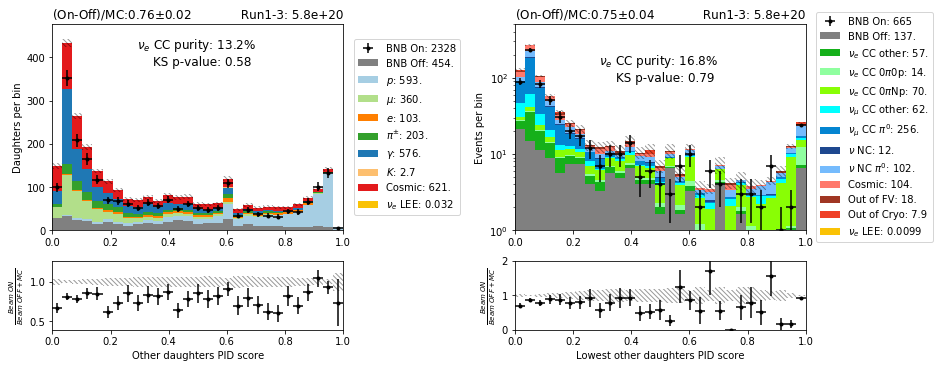

<IPython.core.display.Javascript object>

In [18]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "score",
    "Other daughters PID score",
    N_bins=29,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="pdg",
    y_label="Daughters per bin",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.7,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "score_other_min",
    "Lowest other daughters PID score",
    N_bins=29,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.7,
    ax[0][1].get_ylim()[1] * 0.3,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_ylim(1, 500)
ax[0][1].set_yscale("log")

fig.savefig(output_dir + "pre_daughter_pid.pdf", bbox_inches="tight")

MC category: $p$: 593. 	#entries 31490
MC category: $\mu$: 360. 	#entries 4854
MC category: $e$: 103. 	#entries 17246
MC category: $\pi^{\pm}$: 203. 	#entries 9707
MC category: $\gamma$: 576. 	#entries 14274
MC category: $K$: 2.7 	#entries 98
MC category: Cosmic: 621. 	#entries 21763
MC category: $p$: 593. 	#entries 31490
MC category: $\mu$: 360. 	#entries 4854
MC category: $e$: 103. 	#entries 17246
MC category: $\pi^{\pm}$: 203. 	#entries 9707
MC category: $\gamma$: 576. 	#entries 14274
MC category: $K$: 2.7 	#entries 98
MC category: Cosmic: 621. 	#entries 21763
MC category: $p$: 593. 	#entries 31490
MC category: $\mu$: 360. 	#entries 4854
MC category: $e$: 103. 	#entries 17246
MC category: $\pi^{\pm}$: 203. 	#entries 9707
MC category: $\gamma$: 576. 	#entries 14274
MC category: $K$: 2.7 	#entries 98
MC category: Cosmic: 621. 	#entries 21763


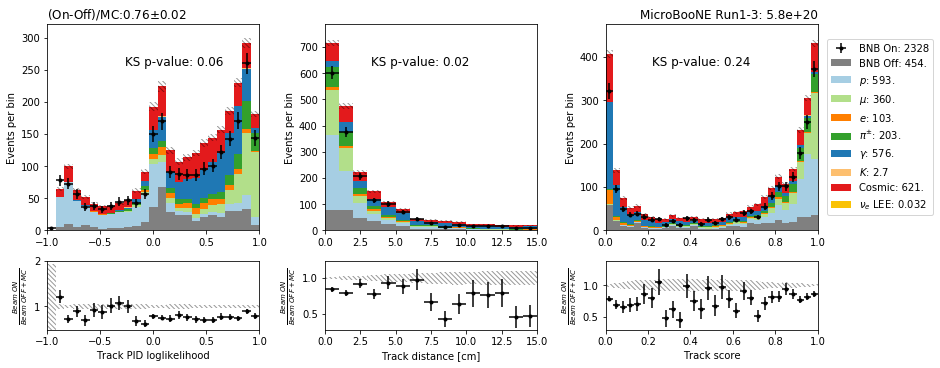

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_llr_pid_score_v",
    "Track PID loglikelihood",
    N_bins=25,
    x_min=-1,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str="",
    kind="pdg",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.7,
    ax[0][0].get_ylim()[1] * 0.8,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_distance_v",
    "Track distance [cm]",
    N_bins=15,
    x_min=0,
    x_max=15,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str="",
    kind="pdg",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.7,
    ax[0][1].get_ylim()[1] * 0.8,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_score_v",
    "Track score",
    N_bins=30,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.7,
    ax[0][2].get_ylim()[1] * 0.8,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")


fig.savefig(output_dir + "pre_daughter_1.pdf", bbox_inches="tight")

MC category: $p$: 593. 	#entries 31490
MC category: $\mu$: 360. 	#entries 4854
MC category: $e$: 103. 	#entries 17246
MC category: $\pi^{\pm}$: 203. 	#entries 9707
MC category: $\gamma$: 576. 	#entries 14274
MC category: $K$: 2.7 	#entries 98
MC category: Cosmic: 621. 	#entries 21763
MC category: $p$: 593. 	#entries 31490
MC category: $\mu$: 360. 	#entries 4854
MC category: $e$: 103. 	#entries 17246
MC category: $\pi^{\pm}$: 203. 	#entries 9707
MC category: $\gamma$: 576. 	#entries 14274
MC category: $K$: 2.7 	#entries 98
MC category: Cosmic: 621. 	#entries 21763
MC category: $p$: 593. 	#entries 31490
MC category: $\mu$: 360. 	#entries 4854
MC category: $e$: 103. 	#entries 17246
MC category: $\pi^{\pm}$: 203. 	#entries 9707
MC category: $\gamma$: 576. 	#entries 14274
MC category: $K$: 2.7 	#entries 98
MC category: Cosmic: 621. 	#entries 21763


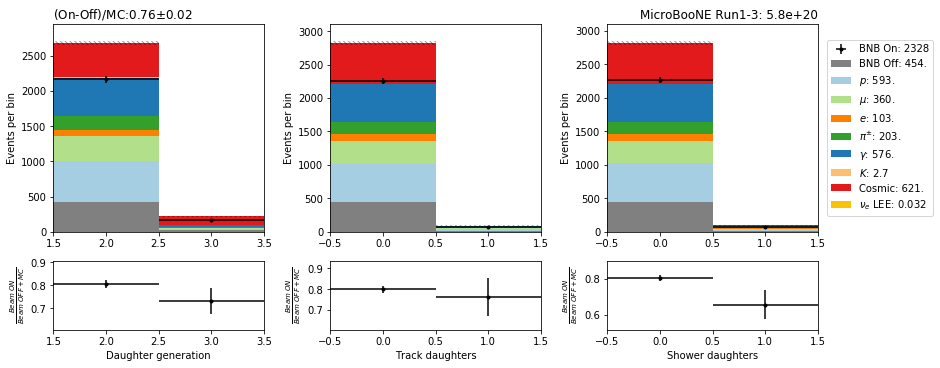

<IPython.core.display.Javascript object>

In [20]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "pfp_generation_v",
    "Daughter generation",
    N_bins=2,
    x_min=1.5,
    x_max=3.5,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str="",
    kind="pdg",
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "pfp_trk_daughters_v",
    "Track daughters",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str="",
    kind="pdg",
)
ax[0][1].set_title("", loc="left")

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "pfp_shr_daughters_v",
    "Shower daughters",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
)
ax[0][2].set_title("", loc="left")

fig.savefig(output_dir + "pre_daughter_2.pdf", bbox_inches="tight")

## Combined BDT
1. feature score (0.623621)
2. feature score_other_mean (0.188310)
3. feature n_showers (0.061185)
4. feature score_other_min (0.043890)
5. feature score_other_max (0.040488)
6. feature n_pfp_farvtx (0.023708)
7. feature contained_fraction (0.018798)

MC category: $\nu_e$ CC other: 57. 	#entries 11295
MC category: $\nu_e$ CC 0$\pi$0p: 14. 	#entries 2343
MC category: $\nu_e$ CC 0$\pi$Np: 70. 	#entries 12211
MC category: $\nu_{\mu}$ CC other: 62. 	#entries 840
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 256. 	#entries 3659
MC category: $\nu$ NC: 12. 	#entries 359
MC category: $\nu$ NC $\pi^{0}$: 102. 	#entries 765
MC category: Cosmic: 104. 	#entries 1452
MC category: Out of FV: 18. 	#entries 227
MC category: Out of Cryo: 7.9 	#entries 8
MC category: $\nu_e$ CC other: 57. 	#entries 11295
MC category: $\nu_e$ CC 0$\pi$0p: 14. 	#entries 2343
MC category: $\nu_e$ CC 0$\pi$Np: 70. 	#entries 12211
MC category: $\nu_{\mu}$ CC other: 62. 	#entries 840
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 256. 	#entries 3659
MC category: $\nu$ NC: 12. 	#entries 359
MC category: $\nu$ NC $\pi^{0}$: 102. 	#entries 765
MC category: Cosmic: 104. 	#entries 1452
MC category: Out of FV: 18. 	#entries 227
MC category: Out of Cryo: 7.9 	#entries 8
MC category: $\nu_e$ CC 

/home/wouter/Public/searchingfornues/helpers/plot_class.py:336: RuntimeWarning: divide by zero encountered in double_scalars
  sc_err = e / v
/home/wouter/Binaries/miniconda3/envs/uproot/lib/python3.7/site-packages/matplotlib/patches.py:716: RuntimeWarning: invalid value encountered in double_scalars
  self._y1 = self._y0 + self._height
/home/wouter/Public/searchingfornues/helpers/plot_class.py:358: RuntimeWarning: invalid value encountered in true_divide
  y_min_r = max(0, min((bins[-1]-err_on)/val)*0.9)
/home/wouter/Public/searchingfornues/helpers/plot_class.py:359: RuntimeWarning: invalid value encountered in true_divide
  y_max_r = min(2, max((bins[-1]+err_on)/val)*1.1)
/home/wouter/Public/searchingfornues/helpers/plot_class.py:365: RuntimeWarning: invalid value encountered in true_divide
  bins[-1] / val,
/home/wouter/Public/searchingfornues/helpers/plot_class.py:367: RuntimeWarning: invalid value encountered in true_divide
  yerr=err_on / val,


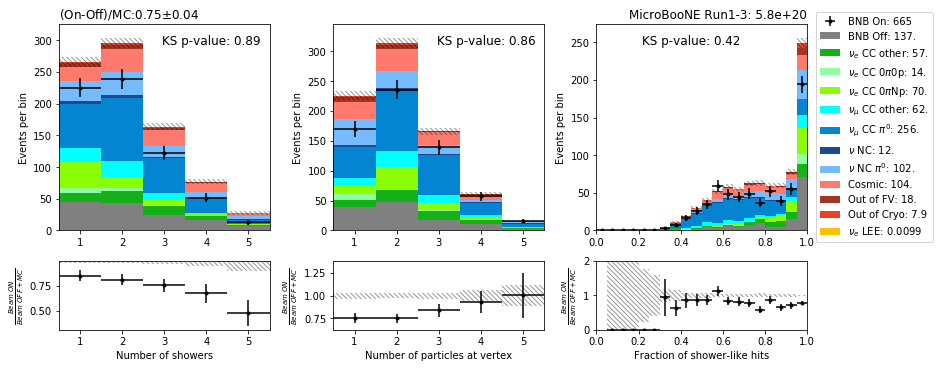

<IPython.core.display.Javascript object>

In [21]:
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[0],
    "n_showers",
    r"Number of showers",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.98,
    ax[0][0].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)

ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "n_pfpvtx",
    r"Number of particles at vertex",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str="",
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.98,
    ax[0][1].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][1].set_title("", loc="left")


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[2],
    "hits_ratio",
    r"Fraction of shower-like hits",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat",
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.7,
    ax[0][2].get_ylim()[1] * 0.9,
    "KS p-value: {0:<5.2f}".format(ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[0][2].set_title("", loc="left")

fig.savefig(output_dir + "event_bdt_input.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC other: 57. 	#entries 11295
MC category: $\nu_e$ CC 0$\pi$0p: 14. 	#entries 2343
MC category: $\nu_e$ CC 0$\pi$Np: 70. 	#entries 12211
MC category: $\nu_{\mu}$ CC other: 62. 	#entries 840
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 256. 	#entries 3659
MC category: $\nu$ NC: 12. 	#entries 359
MC category: $\nu$ NC $\pi^{0}$: 102. 	#entries 765
MC category: Cosmic: 104. 	#entries 1452
MC category: Out of FV: 18. 	#entries 227
MC category: Out of Cryo: 7.9 	#entries 8
MC category: $\nu_e$ CC other: 20. 	#entries 4038
MC category: $\nu_e$ CC 0$\pi$0p: 8.3 	#entries 1368
MC category: $\nu_e$ CC 0$\pi$Np: 46. 	#entries 7963
MC category: $\nu_{\mu}$ CC other: 4.5 	#entries 58
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 4.0 	#entries 63
MC category: $\nu$ NC: 0.23 	#entries 7
MC category: $\nu$ NC $\pi^{0}$: 2.3 	#entries 21
MC category: Cosmic: 2.4 	#entries 54
MC category: Out of FV: 1.8 	#entries 59
MC category: Out of Cryo: 1.8 	#entries 2


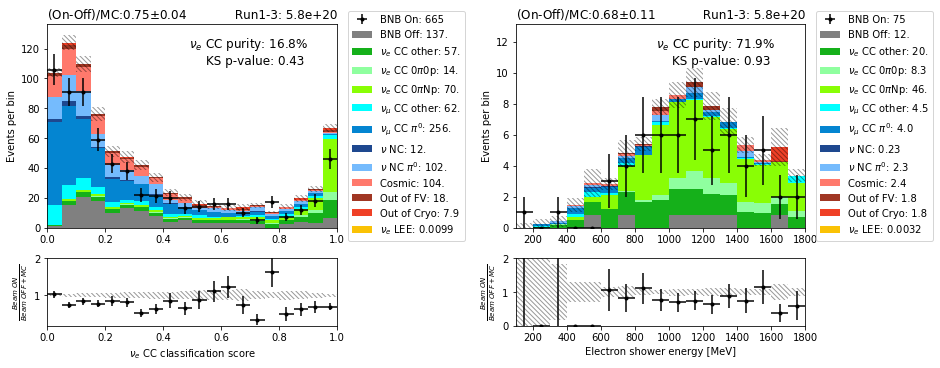

<IPython.core.display.Javascript object>

In [22]:
fig, ax = plt.subplots(
    ncols=2,
    nrows=2,
    figsize=(8 * plotter.gr, 5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "score_event",
    r"$\nu_e$ CC classification score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="(preselect & e_candidate)",
    legend=True,
    title_str=title_str.split("NE")[-1],
    kind="cat",
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.9,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)


ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_energy_y_v",
    "Electron shower energy [MeV]",
    N_bins=17,
    x_min=100,
    x_max=1800,
    query="(select & e_candidate)",
    legend=True,
    title_str=title_str.split("NE")[-1],
    y_max_scaler=1.4,
    kind="cat",
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.9,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)

fig.savefig(output_dir + "final.pdf", bbox_inches="tight")

In [23]:
after_e = [
    0.0724407,
    0.069931,
    0.070793,
    0.0591427,
    0.0580825,
    0.0707208,
    0.0619271,
    0.0631596,
    0.071956,
    0.0823832,
    0.076636,
    0.0799156,
    0.0945661,
    0.107033,
    0.127387,
    0.148529,
    0.0948171,
]

after_phi = [
    0.0629107,
    0.0574177,
    0.0622805,
    0.0734858,
    0.0484628,
    0.0669408,
    0.0615361,
    0.062214,
    0.098453,
    0.0704486,
    0.0610666,
    0.063518,
]
after_theta = [
    0.0631627,
    0.0555099,
    0.0535565,
    0.0719665,
    0.0884092,
    0.071224,
    0.0889857,
    0.110553,
    0.114683,
    0.0920515,
    0.132373,
    0.349061,
]

before_e = [
    0.29716,
    0.265507,
    0.24898,
    0.260043,
    0.269309,
    0.240034,
    0.263073,
    0.279628,
    0.281871,
    0.269588,
    0.269238,
    0.280828,
    0.295573,
    0.296626,
    0.265467,
    0.293,
    0.288306,
]

before_phi = [
    0.220577,
    0.266154,
    0.241005,
    0.365799,
    0.414711,
    0.245414,
    0.222696,
    0.248814,
    0.252192,
    0.220549,
    0.263487,
    0.255388,
]

before_theta = [
    0.220855,
    0.255422,
    0.287287,
    0.245846,
    0.289416,
    0.314501,
    0.323908,
    0.286917,
    0.231717,
    0.255552,
    0.282183,
    0.406976,
]

<IPython.core.display.Javascript object>

MC category: $\nu_e$ CC other: 20. 	#entries 4038
MC category: $\nu_e$ CC 0$\pi$0p: 8.3 	#entries 1368
MC category: $\nu_e$ CC 0$\pi$Np: 46. 	#entries 7963
MC category: $\nu_{\mu}$ CC other: 4.5 	#entries 58
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 4.0 	#entries 63
MC category: $\nu$ NC: 0.23 	#entries 7
MC category: $\nu$ NC $\pi^{0}$: 2.3 	#entries 21
MC category: Cosmic: 2.4 	#entries 54
MC category: Out of FV: 1.8 	#entries 59
MC category: Out of Cryo: 1.8 	#entries 2
MC category: $\nu_e$ CC other: 20. 	#entries 4038
MC category: $\nu_e$ CC 0$\pi$0p: 8.3 	#entries 1368
MC category: $\nu_e$ CC 0$\pi$Np: 46. 	#entries 7963
MC category: $\nu_{\mu}$ CC other: 4.5 	#entries 58
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 4.0 	#entries 63
MC category: $\nu$ NC: 0.23 	#entries 7
MC category: $\nu$ NC $\pi^{0}$: 2.3 	#entries 21
MC category: Cosmic: 2.4 	#entries 54
MC category: Out of FV: 1.8 	#entries 59
MC category: Out of Cryo: 1.8 	#entries 2
MC category: $\nu_e$ CC other: 20. 	#entries 4038


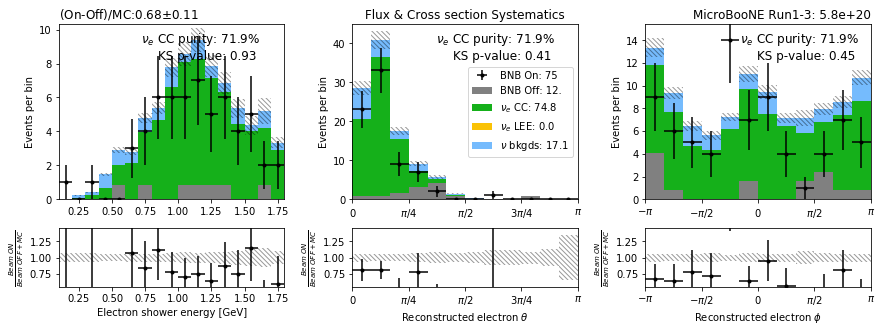

<IPython.core.display.Javascript object>

In [24]:
%autoreload
fig, ax = plt.subplots(
    ncols=3,
    nrows=2,
    figsize=(7.5 * plotter.gr, 4.5),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_energy_y_v/1000",
    "Electron shower energy [GeV]",
    N_bins=17,
    x_min=0.1,
    x_max=1.8,
    query="(select & e_candidate)",
    legend=False,
    title_str="",
    syst_fractions=after_e,
    kind="syst",
    show_data=True,
)
ax[0][0].text(
    ax[0][0].get_xlim()[1] * 0.9,
    ax[0][0].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)


ratio, purity, ks_p, bin_dict = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_theta_v",
    r"Reconstructed electron $\theta$",
    N_bins=12,
    x_min=0.0,
    x_max=np.pi,
    query="(select & e_candidate)",
    legend=False,
    title_str="",
    kind="syst",
    syst_fractions=after_theta,
    show_data=True,
)
ax[0][1].text(
    ax[0][1].get_xlim()[1] * 0.9,
    ax[0][1].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[1][1].set_xticks(helper.theta_ticks)
ax[1][1].set_xticklabels(helper.theta_labs)
ax[0][1].set_xticks(helper.theta_ticks)
ax[0][1].set_xticklabels(helper.theta_labs)
ax[0][1].set_title("", loc="left")
ax[0][1].set_title("Flux & Cross section Systematics")
ax[0][1].legend(loc="center right")

ratio, purity, ks_p, _ = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_phi_v",
    "Reconstructed electron $\phi$",
    N_bins=12,
    x_min=-np.pi,
    x_max=np.pi,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="syst",
    syst_fractions=after_phi,
    show_data=True,
)
ax[0][2].text(
    ax[0][2].get_xlim()[1] * 0.9,
    ax[0][2].get_ylim()[1] * 0.8,
    r"$\nu_e$"
    + " CC purity: {0:<3.1f}%\nKS p-value: {1:<5.2f}".format(purity * 100, ks_p),
    horizontalalignment="right",
    fontsize=12,
)
ax[1][2].set_xticks(helper.phi_ticks)
ax[1][2].set_xticklabels(helper.phi_labs)
ax[0][2].set_xticks(helper.phi_ticks)
ax[0][2].set_xticklabels(helper.phi_labs)
ax[0][2].set_title("", loc="left")


_ = [x.set_ylim(0.55, 1.45) for x in ax[1]]

fig.savefig(
    output_dir + "thesis_electron_kinematics_after.pdf", bbox_inches="tight",
)